In [6]:
!pip install matplotlib
!pip install tqdm
!pip install tensorboard
!pip install pycootools

ERROR: Could not find a version that satisfies the requirement pycootools (from versions: none)
ERROR: No matching distribution found for pycootools


In [1]:
import json
import os
import time
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import cProfile

import torch as torch 
import torchvision
# import torch.nn as nn
import torch.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.tensorboard as tensorboard 
%load_ext tensorboard
%tensorboard --logdir = runs
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

# from torchvision.datasets import CocoDetection
# from torchvision.io import read_image
# from torchvision import tv_tensors
# from torchvision.ops.boxes import masks_to_boxes
# from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from pycocotools.coco import COCO

from PIL import Image

In [2]:
import torch

print(f"{torch.__version__=}")
print(f"{torch.cuda.get_device_name()=}")

torch.__version__='2.3.1+cu121'
torch.cuda.get_device_name()='NVIDIA GeForce GTX 1650'


# Take 1

In [2]:
# data = torchvision.datasets.CIFAR10(
#     root='./',
#     train=True,
#     download=True,
#     transform= transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5,),(0.5,))]
#     )
# )
# train_loader = DataLoader(
#     data, batch_size= 64, shuffle=True
# )

In [3]:
# img, lbl = next(iter(train_loader))


In [4]:
def get_subset_of_images(annFile, num_images):
    with open(annFile, 'r') as f:
        annotations = json.load(f)
    image_ids = [img['id'] for img in annotations['images']]
    return image_ids[:num_images]

In [5]:
train_annFile = 'D:/Codes/Python-Scripts/coco2017/annotations/instances_train2017.json'
get_subset_ann = get_subset_of_images(train_annFile, 10)
print(get_subset_ann)

[391895, 522418, 184613, 318219, 554625, 574769, 60623, 309022, 5802, 222564]


In [ ]:
# def load_image(path):
#     img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
#     if img is None:
#         print(f'Error opening image: {path}')
#         return None
#     return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
class CustomCOCO(Dataset):
    def __init__(self, root, annFile ,image_ids, transform= None):
        self.root = root
        self.coco = datasets.coco.COCO(annFile)
        self.image_ids = image_ids
        self.ids = list(set(self.getImgIds())& set(image_ids))
        self.transform = transform
        
        # self.all_annotations = {img_id : self.coco.loadAnns(self.coco.getAnnIds(imgIds = img_id)) for img_id in image_ids}
        # self.all_images = {img_id: Image.open(os.path.join(self.root, img_info['file_name'])).convert('RGB') for img_id, img_info in zip(image_ids, self.coco.loadImgs(image_ids))}
        # self.imgs = list(sorted(os.listdir(os.path.join(root, 'Images'))))
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        img_id = self.ids[index]
        print(f'image id: {img_id}')
        ann_id = self.coco.getAnnIds(imgIds = img_id)
        annotations = self.coco.loadAnns(ann_id)
        #Loading the image
        img_info = self.coco.loadImgs(img_id)[0]
        # print(f'img_info: {img_info}')
        path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(os.path.join(self.root, path))
        
        #Annotations
        # annotations = self.all_annotations[img_id]
        
        #Transform
        if self.transform:
            img = self.transform(img)
        # print(f'img_type: {type(img)}, annotation_type: {type(annotations)}')
        target = {}
        target['boxes'] = torch.as_tensor([ann['bbox'] for ann in annotations], dtype= torch.float32)
        target['labels'] = torch.as_tensor([ann['category_id'] for ann in annotations], dtype=torch.int64)
        target['image_id'] = torch.tensor([img_id])
        target['area'] = torch.as_tensor([ann['area'] for ann in annotations], dtype=torch.float32)
        target['iscrowd'] = torch.as_tensor([ann['iscrowd'] for ann in annotations], dtype=torch.int64)

        return img, target

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.3),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels= 1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [ ]:
train_root = 'D:/Codes/Python-Scripts/coco2017/train2017'
train_annFile = 'D:/Codes/Python-Scripts/coco2017/annotations/instances_train2017.json'
#fetches 10 images
image_ids_subset = get_subset_of_images(train_annFile, 10)

train_dataset = CustomCOCO(
    root= train_root,
    annFile= train_annFile,
    image_ids = image_ids_subset,
    transform= transform
)

In [ ]:

img, ann = train_dataset[0]
print(f'img shape:{img.shape}')
# json.dump(ann)
print(f'ann: { ann, len(ann)}')
ann = train_dataset
print(ann)
plt.imshow(img.permute(1,2,0))
plt.show()

In [ ]:
all_annotations = []
for idx in range(len(train_dataset)):
    img, ann = train_dataset[idx]
    print(img.shape)
    all_annotations.append(ann)

In [ ]:
all_annotations[1][0]['segmentation']

In [ ]:
len(all_annotations)


In [ ]:
all_annotations[0]

In [ ]:
all_annotations[1][0]['segmentation']

In [ ]:
unique_cat_id = set()
for index in range(len(all_annotations)):
    cat_id = all_annotations[index][0]['category_id']
    unique_cat_id.add(cat_id)

In [ ]:
print(len(unique_cat_id))

In [ ]:
print(unique_cat_id)

In [ ]:
val_root = 'D:/Codes/Python-Scripts/coco2017/val2017'
val_annFile = 'D:/Codes/Python-Scripts/coco2017/annotations/captions_val2017.json'

val_dataset = CustomCOCO(
    root= val_root,
    annFile= val_annFile,
    image_ids = image_ids_subset
)

In [ ]:
#Checking the number of cores in cpu
num_worker = multiprocessing.cpu_count()
num_worker

In [ ]:
for item in train_dataset:
    print(item)

In [ ]:
def custom_collate_fn(batch):
    images = [items[0] for items in batch]
    annotations = [items[1] for items in batch]
    annotation_len = [len(annotation) for annotation in annotations]

    max_len = max(annotation_len)

    for i in range(len(annotations)):
        annotations[i] += [{'category_id':-1, 'bbox':[-1, -1, -1, -1]} for _ in range(max_len - annotation_len[i])]

    return  images, annotations

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size= 10, shuffle= True, num_workers= 0, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size = 10, shuffle= True, num_workers= 0)

In [ ]:
print(f'len train dataset: {len(train_dataloader)}')
print(f'len val dataset: {len(val_dataloader)}')

In [ ]:
print(f'started dataier {time.time()}')
dataiter = iter(train_dataloader)
print(f'completed dataier {time.time()}')

In [ ]:
print(dataiter.__len__())

In [ ]:
dataiter._next_index()

In [ ]:
idx_data= next(dataiter)
idx_data

In [ ]:
dataiter.__len__()

In [ ]:
data = dataiter._next_data()
data

In [ ]:
img, ann = next(iter(train_dataloader))

In [ ]:
img

In [ ]:
train_dataloader = tqdm(train_dataloader)
print(f'about to enter for loop: {time.time()}')
for img, ann in train_dataloader:
    print(f'entered for loop at t: {time.time()}')
    print(f'done loading image with shape: {img}')

In [ ]:
def profile_data_loading():
    images, ann = next(iter(train_dataloader))
cProfile.run('profile_data_loading()', sort = 'cumtime')

In [ ]:
#profiling data loading
# start_time = time.time()
# batch = next(iter(train_dataloader))
# end_time = time.time()
# print(f'Total time to load {batch} is {end_time-start_time}')

## Training with a pretrained backbone model

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

num_classes = 80

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# for images, ann in train_dataloader:
images, targets = next(iter(train_dataloader))
processed_targets =[]
for target in targets:
    # boxes = target[0]['bbox']
    print(f'boxes : {target}')
#     boxes = torch.tensor(boxes)
#     other_info = {k: v for k, v in target.items() if k != 'bbox'}  # Filter out 'bbox'

#   # Combine processed boxes and other information
#     processed_target = {**other_info, 'boxes': boxes}

#   # Append to the processed list
#     processed_targets.append(processed_target)

# # Replace targets with processed version
# targets = processed_targets

# # images = list(image for image in images)
# # targets = [{k:v for k, v in t.items()} for t in targets[0]]
# # targets = [{'boxes': t['bbox']} for t in targets]
# output = model(images, targets)
# print(output)

In [ ]:
#once the above one is successful let's make a custom backbone

# Take 2

In [3]:
def get_subset_of_images(annFile, num_images):
    with open(annFile, 'r') as f:
        annotations = json.load(f)
    image_ids = [img['id'] for img in annotations['images']]
    return image_ids[:num_images]

In [4]:
class CustomCOCO(Dataset):
    def __init__(self, root, annFile, image_ids, transform=None):
        self.root = root
        self.coco = COCO(annFile)
        self.image_ids = image_ids
        self.ids = list(set(self.coco.getImgIds()) & set(image_ids))
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_id = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_id)
        img_info = self.coco.loadImgs(img_id)[0]
        path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(path).convert('RGB')

        if self.transform:
            img = self.transform(img)
        boxes = []
        valid_annotations = []

        for ann in annotations:
            x_min, y_min, width, height = ann['bbox']
            if width > 0 and height > 0:
                boxes.append([x_min, y_min, x_min + width, y_min + height])
                valid_annotations.append(ann)

        if len(valid_annotations) == 0:
            target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros((0,), dtype=torch.int64),
                'image_id': torch.tensor([img_id]),
                'area': torch.zeros((0,), dtype=torch.float32),
                'iscrowd': torch.zeros((0,), dtype=torch.int64)
            }
        else:
            target = {
                'boxes': torch.as_tensor(boxes, dtype=torch.float32),
                'labels': torch.as_tensor([ann['category_id'] for ann in valid_annotations], dtype=torch.int64),
                'image_id': torch.tensor([img_id]),
                'area': torch.as_tensor([ann['area'] for ann in valid_annotations], dtype=torch.float32),
                'iscrowd': torch.as_tensor([ann['iscrowd'] for ann in valid_annotations], dtype=torch.int64)
            }

        return img, target

In [5]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.3),
    # transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels= 1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [6]:
CURR_PATH = os.getcwd()

In [7]:
train_root = f'{CURR_PATH}/coco2017/train2017'
train_annFile = f'{CURR_PATH}/coco2017/annotations/instances_train2017.json'
#fetches 10 images
image_ids_subset = get_subset_of_images(train_annFile, 160)

train_dataset = CustomCOCO(
    train_root,
    train_annFile,
    image_ids= image_ids_subset,
    # skip_ids=None,
    transform=transform
)

loading annotations into memory...
Done (t=18.15s)
creating index...
index created!


In [8]:
train_dataloader = DataLoader(
    train_dataset, shuffle= False,
    batch_size= 10, num_workers=0,
    collate_fn=lambda x: tuple(zip(*x))
)

In [9]:
images, targets = next(iter(train_dataloader))

In [182]:
len(targets)

5

In [183]:
images[0]
# Returns tensors of images

tensor([[[-0.5922, -0.6157, -0.5686,  ...,  0.2784,  0.2549,  0.2471],
         [-0.5608, -0.6078, -0.5922,  ...,  0.2706,  0.2549,  0.2549],
         [-0.5922, -0.6157, -0.6000,  ...,  0.2627,  0.2471,  0.2314],
         ...,
         [-0.5529, -0.5843, -0.4745,  ..., -0.9765, -0.9843, -0.9765],
         [-0.5059, -0.6078, -0.6471,  ..., -0.9765, -0.9843, -0.9765],
         [-0.4039, -0.6392, -0.6706,  ..., -0.9686, -0.9765, -0.9686]]])

`{'boxes': [[439.18, 133.93, 16.21, 33.35],
   [2.15, 144.34, 77.49, 235.7],
   [69.03, 101.06, 236.23, 311.73],
   [362.98, 149.67, 277.02, 235.01],
   [249.1, 342.77, 107.51, 62.92],
   [61.69, 279.88, 66.28, 115.33],
   [29.4, 322.61, 45.32, 64.26],
   [1.25, 375.27, 637.09, 98.5]],
  'labels': [44, 1, 1, 78, 79, 79, 79, 67],
  'image_id': [222564],
  'area': [429.46674999999954,
   7545.5430000000015,
   41732.2215,
   57588.212100000004,
   5349.635100000001,
   2945.321049999999,
   2261.3040499999993,
   33356.58024999999],
  'iscrowd': [0, 0, 0, 0, 0, 0, 0, 0]}`

In [11]:
targets[0]

{'boxes': tensor([[172.1300, 360.8500, 211.7000, 406.6800],
         [199.5800, 351.6000, 283.1700, 420.6200],
         [298.0100, 372.1300, 341.9500, 410.7900],
         [341.6700, 390.8900, 364.6900, 409.5700],
         [270.2300, 365.1800, 301.9100, 412.7000],
         [417.2600, 404.9300, 428.2600, 413.4100],
         [363.1000, 397.4400, 378.7000, 410.2600],
         [218.0700, 183.3200, 377.0000, 230.2200],
         [379.9200, 402.1300, 390.2300, 410.5300],
         [  0.0000, 352.7700,  49.3200, 426.0000]]),
 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 5, 3, 3]),
 'image_id': tensor([81922]),
 'area': tensor([1273.9928, 4687.5640, 1312.7367,  363.2119,  869.6754,   77.4430,
          168.9075, 2586.7922,   72.8781, 2239.1770]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [184]:
from torchvision.transforms import functional as F
import matplotlib.patches as patches


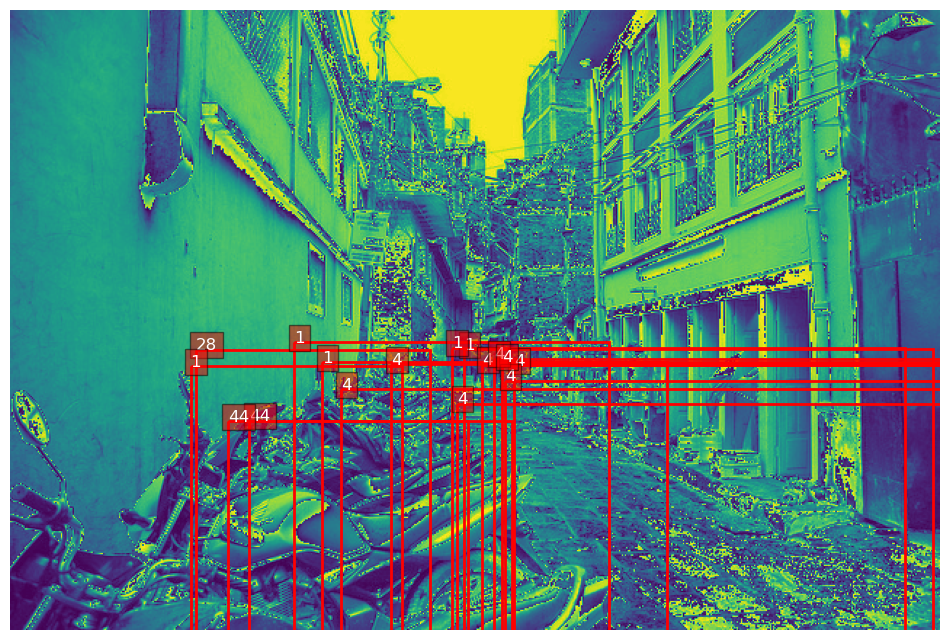

In [186]:
def visualize_image_with_boxes(img, target):
    """
    Visualizes the image with its bounding boxes.

    Args:
        img: PIL Image or Tensor image.
        target: Dictionary containing bounding boxes and labels.
    """
    if isinstance(img, torch.Tensor):
        img = F.to_pil_image(img)

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img)

    boxes = target['boxes'].numpy() if isinstance(target['boxes'], torch.Tensor) else target['boxes']
    labels = target['labels'].numpy() if isinstance(target['labels'], torch.Tensor) else target['labels']

    for i, box in enumerate(boxes):
        x_min, y_min, width, height = box
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min, str(labels[i]), color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()
img, target = train_dataset[0]
visualize_image_with_boxes(img, target)

In [187]:
target

{'boxes': tensor([[261.9600, 243.7300, 559.4200, 409.7300],
         [227.4100, 260.8400, 640.0000, 422.0400],
         [346.0900, 244.2400, 359.7300, 255.5100],
         [307.2400, 270.6600, 505.0400, 335.5200],
         [340.3300, 255.1500, 406.7900, 279.6200],
         [195.1000, 228.4000, 216.8200, 302.3200],
         [214.4000, 242.3600, 237.3700, 293.0300],
         [127.4900, 233.6300, 161.1800, 286.6400],
         [311.9500, 233.2800, 322.5700, 261.1900],
         [324.6000, 244.1000, 439.4900, 292.7100],
         [164.2400, 282.3400, 181.0600, 312.3000],
         [303.5800, 232.2900, 311.5500, 259.9000],
         [123.7600, 244.9400, 145.2900, 305.7500],
         [149.3800, 282.7300, 165.2300, 312.0600],
         [332.3200, 239.7900, 402.3200, 275.2200],
         [337.9500, 242.0200, 393.1300, 265.1700]]),
 'labels': tensor([ 4,  4,  4,  4,  4,  1,  1, 28,  1,  4, 44,  1,  1, 44,  4,  4]),
 'image_id': tensor([394240]),
 'area': tensor([22372.2617, 15076.7422,    76.7302,  689

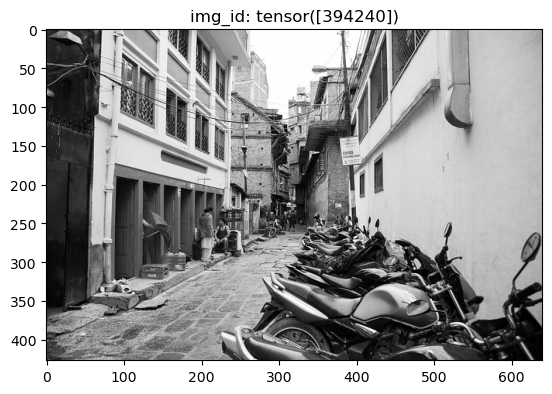

In [188]:
# images[0].size()
plt.imshow(images[0].permute(1,2,0), cmap='grey')
targ_id = targets[0]['image_id']
plt.title(f'img_id: {targ_id}')
plt.show()
# plt.axis('off')

In [189]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights= 'DEFAULT')

num_classes = 80

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictpr = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(
    params= params, lr= 0.005,
    momentum= 0.9, weight_decay= 0.0005
)

In [190]:
torch.cuda.empty_cache()

In [191]:
val_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.3),
    # transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels= 1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [192]:
val_root = f'{CURR_PATH}/coco2017/val2017'
val_annFile = f'{CURR_PATH}/coco2017/annotations/instances_val2017.json'
image_ids_subset = get_subset_of_images(val_annFile, 10) 
val_dataset = CustomCOCO(
    root= val_root,
    annFile= val_annFile,
    image_ids = image_ids_subset,
    transform=val_transform
)

validation_dataloader = DataLoader(
    val_dataset, shuffle= True,
    batch_size=5, num_workers=0,
    collate_fn= lambda x: tuple(zip(*x))
)

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


In [ ]:
writer = tensorboard.writer.SummaryWriter()

In [193]:
num_epochs = 16
scaler = GradScaler()
for epoch in range(num_epochs):
    model.train()
    losses = 0.0
    for batch, (images, targets )in enumerate(train_dataloader):
        images = [(img.to(device) for img in images)]

        targets =[{k:v.to(device) for k, v in t.items()} for t in targets]

        with autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        if batch%10==0:
            print(f'Batch [{batch}/{len(train_dataloader)}], Loss: {losses.item()}')
    epoch_loss = losses/len(train_dataloader)
    print(f'Epoch: [{epoch+1}/{num_epochs}], epoch_loss: {epoch_loss}')
    writer.add_scalar(epoch, epoch_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
    
            val_loss += loss.item()
    
    val_loss /= len(val_dataloader)
    print(f'Validation Loss: {val_loss:.4f}')

lossdict: {'loss_classifier': tensor(0.4406, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2400, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(1.7052, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.1421, device='cuda:0', grad_fn=<DivBackward0>)}
lossdict: {'loss_classifier': tensor(0.1409, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0205, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(2.1073, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0855, device='cuda:0', grad_fn=<DivBackward0>)}
lossdict: {'loss_classifier': tensor(0.1903, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0642, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.2276, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0

In [ ]:
torch.save(model.state_dict(), 'best_model.pth')
# Aaaaaaaaaa I shud have done this yesterday :painful:

In [19]:
torch.save(model.state_dict(), 'custom_fasterrcnn.pth')

In [20]:
checkpoint_path = 'D:/Codes/Python-Scripts/DS/neural-nets/images-nets/custom_fasterrcnn.pth'
checkpoint = torch.load(checkpoint_path)

In [21]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [99]:
img, targ = next(iter(validation_dataloader))

In [101]:
len(img)

5

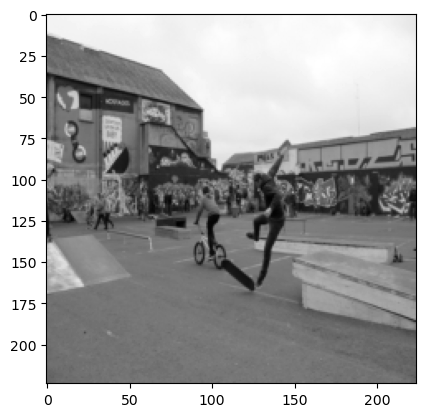

In [109]:
plt.imshow(img[4].permute(1,2,0), cmap='gray')

In [134]:
model.eval()
validation_loss = 0.0
with torch.no_grad():
    for val_img, val_targets in validation_dataloader:
        val_img = list(img.to(device) for img in val_img)
        val_targets = [{k:v.to(device) for k,v in t.items()}for t in val_targets]
        
        ouputs = model(val_img)
        count = 0
        try:
            val_loss_dict = model(val_img, val_targets)
            # val_losses = sum(val_loss for val_loss in val_loss_dict.values())
            # for items in val_loss_dict:
            #     count+=1
            #     print(f'{count} : {items}')
            print(val_loss_dict)
            # validation_loss += val_losses.item()
        except Exception as e:
            print(f'Skipping batch due to error:{e}')
avg_val_loss = val_losses / len(validation_dataloader)
print(f'Validation Loss: {avg_val_loss}')

[{'boxes': tensor([[ 23.3435, 138.7372, 112.7581, 220.1486],
        [131.9277,  30.8722, 178.5892, 114.2211],
        [ 11.6042, 180.2424,  34.2405, 203.5707],
        [ 80.8022, 135.9583,  89.5944, 156.1709],
        [ 81.0016, 140.7217,  89.3196, 156.1505],
        [ 10.6083, 179.5352,  34.5340, 204.8241],
        [116.8307,   8.3674, 211.0311, 166.3140],
        [ 20.5451, 149.9721,  46.5856, 170.0273],
        [  0.2858, 159.7593,  29.3017, 184.0793],
        [167.7807,  77.4825, 205.6501, 107.6856],
        [ 43.5024,   5.6234, 194.5138, 224.0000],
        [  0.0000,  15.5978, 129.3051, 219.2409],
        [137.4933,  43.0019, 172.4054,  96.8477],
        [  0.9581, 161.0475,  30.3272, 183.1990],
        [ 59.0385,   4.8390, 216.6119, 118.4529]], device='cuda:0'), 'labels': tensor([15,  1, 51, 44, 47, 70,  1,  3, 64, 15,  1,  1,  1, 67,  1],
       device='cuda:0'), 'scores': tensor([0.6578, 0.5692, 0.5280, 0.4243, 0.3156, 0.1963, 0.1664, 0.1240, 0.0976,
        0.0957, 0.0918, 0.

In [136]:
import cv2

torch.Size([1, 3, 427, 640])


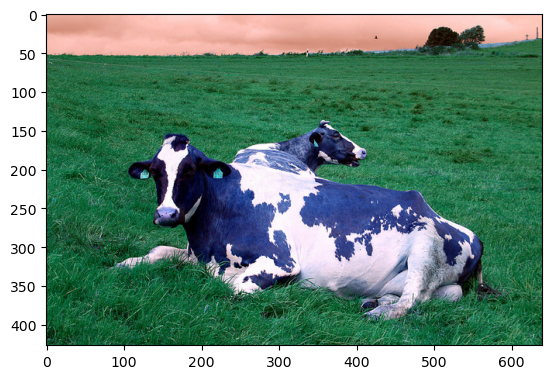

In [172]:
img = cv2.imread(f'{CURR_PATH}/coco2017/test2017/000000000019.jpg')

tranSformed_test_img = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])
img = tranSformed_test_img(img)
plt.imshow(img.permute(1,2,0), cmap='gray')
img = img.unsqueeze(dim = 0).to(device)
# img = img.to(device)
print(img.size())
model.eval()
pred = model(img)

In [173]:
pred

[{'boxes': tensor([[112.1500, 146.0323, 569.9775, 390.8580],
          [236.5788, 136.8998, 415.4568, 206.0566],
          [ 87.8024, 157.4899, 380.8655, 355.9829],
          [ 82.8398, 296.9329, 198.3799, 328.1281],
          [499.6300, 348.3781, 537.2842, 371.6313],
          [424.2056,  27.6963, 428.0742,  32.1260],
          [239.2797, 162.5559, 354.2720, 199.8242],
          [ 85.7303, 296.5549, 208.1842, 334.6025],
          [ 85.9931, 261.7420, 330.5946, 358.8301],
          [239.7453, 165.8937, 314.9850, 192.5612],
          [304.6351, 213.7606, 562.2536, 396.4579],
          [ 96.7462, 157.2504, 276.7622, 308.1171],
          [336.0014,  44.6630, 339.6700,  56.0469],
          [ 84.7611, 309.3430, 185.4888, 329.9744],
          [424.0427,  27.8678, 428.1181,  32.3874],
          [ 83.1950, 290.0262, 286.1343, 349.2257]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([21, 21, 21, 20, 37, 16, 21, 21, 21, 21, 21, 21,  1, 20, 38, 21],
         device='cud

In [174]:
print(type(img))

<class 'torch.Tensor'>


In [175]:
pred[0]['boxes'] = pred[0]['boxes'].detach().cpu()

In [176]:
pred[0]['labels'] = pred[0]['labels'].detach().cpu()

In [177]:
print(type(pred[0]['boxes']))

<class 'torch.Tensor'>


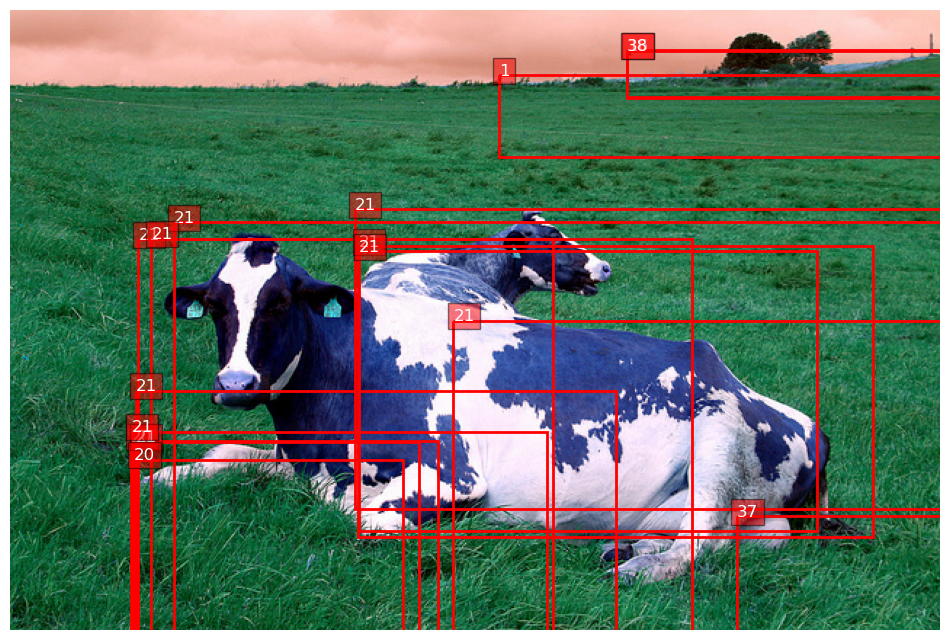

In [178]:
visualize_image_with_boxes(img.squeeze(), pred[0])